In [1]:
import os
import math
import time
import heapq
import random
import json
import zipfile
import io
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from google.colab import files
import matplotlib.pyplot as plt


In [3]:
# Upload maze zip
uploaded = files.upload()
for fname in uploaded:
    with zipfile.ZipFile(io.BytesIO(uploaded[fname])) as zip_ref:
        zip_ref.extractall("imperfect_maze")

input_dir = "imperfect_maze/imperfect_maze"
maze_files = [os.path.join(input_dir, f) for f in sorted(os.listdir(input_dir)) if f.endswith(".txt")]


Saving imperfect_maze.zip to imperfect_maze.zip


In [15]:
# Split maze files into training and testing sets
def split_mazes(maze_files, train_frac=0.2, seed=42):
    random.seed(seed)
    random.shuffle(maze_files)
    split = int(len(maze_files) * train_frac)
    return maze_files[:split], maze_files[split:]

train_mazes, test_mazes = split_mazes(maze_files)
print(f"{len(train_mazes)} training mazes, {len(test_mazes)} testing mazes")


300 training mazes, 1200 testing mazes


In [5]:
def load_maze(path):
    return np.loadtxt(path, dtype=int)

In [6]:
def q_heuristic(state):
    return -max(Q.get(state, {}).values(), default=0)

def manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def manhattan_heuristic(state):
    return manhattan(state, goal)

def euclidean_heuristic(state):
    return ((state[0] - goal[0]) ** 2 + (state[1] - goal[1]) ** 2) ** 0.5

In [7]:
class TabularQLearning:
    def __init__(self, actions, discount=1.0, explorationProb=0.2, initialQ=0.0, step_size=0.5):
        self.Q = {}
        self.actions = actions
        self.discount = discount
        self.explorationProb = explorationProb
        self.initialQ = initialQ
        self.step_size = step_size

    def getQ(self, state, action):
        return self.Q.get(state, {}).get(action, self.initialQ)

    def choose_action(self, state):
        if random.random() < self.explorationProb:
            return random.choice(self.actions)
        qs = [(a, self.getQ(state, a)) for a in self.actions]
        maxQ = max(qs, key=lambda x: x[1])[1]
        best_actions = [a for a, q in qs if q == maxQ]
        return random.choice(best_actions)

    def update(self, state, action, reward, next_state):
        oldQ = self.getQ(state, action)
        max_future_q = max([self.getQ(next_state, a) for a in self.actions], default=0)
        target = reward + self.discount * max_future_q
        newQ = oldQ + self.step_size * (target - oldQ)
        if state not in self.Q:
            self.Q[state] = {}
        self.Q[state][action] = newQ


In [8]:
def astar(maze, start, goal, heuristic):
    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}

    while frontier:
        _, current = heapq.heappop(frontier)
        if current == goal:
            break
        for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            next_state = (current[0] + dr, current[1] + dc)
            if (
                0 <= next_state[0] < maze.shape[0]
                and 0 <= next_state[1] < maze.shape[1]
                and maze[next_state] == 0
            ):
                new_cost = cost_so_far[current] + 1
                if next_state not in cost_so_far or new_cost < cost_so_far[next_state]:
                    cost_so_far[next_state] = new_cost
                    priority = new_cost + heuristic(next_state)
                    heapq.heappush(frontier, (priority, next_state))
                    came_from[next_state] = current
    return came_from, cost_so_far


In [9]:
def train_q_learning_reversed(maze, goal, actions,
                                      discount, explorationProb, step_size,
                                      num_sample_starts, step_multiplier):
    q = TabularQLearning(actions, discount=discount,
                         explorationProb=explorationProb,
                         step_size=step_size)
    height, width = maze.shape
    max_steps = step_multiplier * (height + width)

    def is_valid(pos):
        r, c = pos
        return 0 <= r < height and 0 <= c < width and maze[r, c] == 0

    free_cells = [tuple(cell) for cell in np.argwhere(maze == 0)]
    sample_starts = random.sample(free_cells, min(num_sample_starts, len(free_cells)))

    episodes = 500
    for ep in range(episodes):
        state = goal
        for _ in range(max_steps):
            action = q.choose_action(state)
            next_state = (state[0] + action[0], state[1] + action[1])
            if not is_valid(next_state):
                continue
            reward = 0 if next_state in sample_starts else -1
            q.update(state, action, reward, next_state)
            state = next_state
    return q.Q


In [10]:
def evaluate_runtime(config, maze, start, goal, actions):
    Q = train_q_learning_reversed(
        maze, goal, actions,
        discount=config["discount"],
        explorationProb=config["explorationProb"],
        step_size=config["step_size"],
        num_sample_starts=config["num_sample_starts"],
        step_multiplier=config["step_multiplier"]
    )

    def q_heuristic(state):
        return -max(Q.get(state, {}).values(), default=0)

    start_time = time.time()
    came_from, cost = astar(maze, start, goal, q_heuristic)
    return time.time() - start_time


In [11]:
def run_single_map_search(path, actions, n_trials=30):
    maze = load_maze(path)
    free_cells = list(zip(*np.where(maze == 0)))
    if len(free_cells) < 2:
        return None
    start = free_cells[0]
    goal = free_cells[-1]

    result = []
    for _ in range(n_trials):
        config = {
            "discount": round(random.uniform(0.8, 1.0), 2),
            "explorationProb": round(random.uniform(0.1, 0.7), 2),
            "step_size": round(random.uniform(0.1, 0.9), 2),
            "num_sample_starts": random.randint(3, 20),
            "step_multiplier": random.randint(5, 20)
        }
        try:
            runtime = evaluate_runtime(config, maze, start, goal, actions)
            config["runtime"] = runtime
            config["maze"] = os.path.basename(path)
            result.append(config)
        except Exception as e:
            print(f"Failed on {path}: {e}")
    return result


In [12]:
def run_hyperparameter_search(train_mazes, n_maps=30, n_trials_per_map=30):
    selected_paths = random.sample(maze_files, min(n_maps, len(maze_files)))
    actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    all_results = []

    for map_idx, path in enumerate(selected_paths):
        print(f"\n Running map {map_idx + 1}/{len(selected_paths)}: {os.path.basename(path)}")
        maze = load_maze(path)
        free_cells = list(zip(*np.where(maze == 0)))
        if len(free_cells) < 2:
            print("Skipping map due to insufficient free space.")
            continue
        start = free_cells[0]
        goal = free_cells[-1]

        for trial in range(n_trials_per_map):
            config = {
                "discount": round(random.uniform(0.8, 1.0), 2),
                "explorationProb": round(random.uniform(0.1, 0.7), 2),
                "step_size": round(random.uniform(0.1, 0.9), 2),
                "num_sample_starts": random.randint(3, 20),
                "step_multiplier": random.randint(5, 20)
            }
            try:
                print(f"Trial {trial + 1}/{n_trials_per_map}", end="\\r")
                runtime = evaluate_runtime(config, maze, start, goal, actions)
                config["runtime"] = runtime
                config["maze"] = os.path.basename(path)
                all_results.append(config)
            except Exception as e:
                print(f"Trial {trial + 1} failed: {e}")

    df = pd.DataFrame(all_results)
    df.to_csv("hyperparameter_results.csv", index=False)
    with open("hyperparameter_results.json", "w") as f:
        json.dump(all_results, f, indent=2)
    return df



In [13]:
results_df = run_hyperparameter_search(
    train_mazes,
    n_maps=30,
    n_trials_per_map=30
)
results_df.head()
# Training time:


 Running map 1/30: maze970_dim25.txt
Trial 1/30\rTrial 2/30\rTrial 3/30\rTrial 4/30\rTrial 5/30\rTrial 6/30\rTrial 7/30\rTrial 8/30\rTrial 9/30\rTrial 10/30\rTrial 11/30\rTrial 12/30\rTrial 13/30\rTrial 14/30\rTrial 15/30\rTrial 16/30\rTrial 17/30\rTrial 18/30\rTrial 19/30\rTrial 20/30\rTrial 21/30\rTrial 22/30\rTrial 23/30\rTrial 24/30\rTrial 25/30\rTrial 26/30\rTrial 27/30\rTrial 28/30\rTrial 29/30\rTrial 30/30\r
 Running map 2/30: maze1443_dim16.txt
Trial 1/30\rTrial 2/30\rTrial 3/30\rTrial 4/30\rTrial 5/30\rTrial 6/30\rTrial 7/30\rTrial 8/30\rTrial 9/30\rTrial 10/30\rTrial 11/30\rTrial 12/30\rTrial 13/30\rTrial 14/30\rTrial 15/30\rTrial 16/30\rTrial 17/30\rTrial 18/30\rTrial 19/30\rTrial 20/30\rTrial 21/30\rTrial 22/30\rTrial 23/30\rTrial 24/30\rTrial 25/30\rTrial 26/30\rTrial 27/30\rTrial 28/30\rTrial 29/30\rTrial 30/30\r
 Running map 3/30: maze1384_dim14.txt
Trial 1/30\rTrial 2/30\rTrial 3/30\rTrial 4/30\rTrial 5/30\rTrial 6/30\rTrial 7/30\rTrial 8/30\rTrial 9/30\rTrial 10/30\rT

,discount,explorationProb,step_size,num_sample_starts,step_multiplier,runtime,maze
0,0.92,0.49,0.65,3,10,0.005507,maze970_dim25.txt
1,0.96,0.60,0.71,16,10,0.005548,maze970_dim25.txt
2,0.92,0.59,0.25,12,12,0.005568,maze970_dim25.txt
3,0.85,0.55,0.37,8,15,0.005632,maze970_dim25.txt
4,0.98,0.46,0.74,3,18,0.006036,maze970_dim25.txt


In [16]:
#DELETE THS
import os
import random

# Ensure reproducibility
random.seed(42)

# Step 1: Get maze filenames used in tuning
used_in_training = set(results_df["maze"].unique())

# Step 2: Remove test mazes that were used in tuning
clean_test_mazes = [m for m in test_mazes if os.path.basename(m) not in used_in_training]

# Step 3: Count how many test mazes were removed
n_missing = len(test_mazes) - len(clean_test_mazes)
print(f"{n_missing} test mazes were used in training and will be replaced.")

# Step 4: Sample replacements from unused training mazes
available_replacements = [m for m in train_mazes if os.path.basename(m) not in used_in_training]
if n_missing > len(available_replacements):
    raise ValueError("Not enough clean training mazes to replace contaminated test mazes.")

new_test_samples = random.sample(available_replacements, n_missing)

# Step 5: Final corrected test set
final_test_mazes = clean_test_mazes + new_test_samples
print(f"Final test set contains {len(final_test_mazes)} mazes.")


26 test mazes were used in training and will be replaced.
Final test set contains 1200 mazes.


In [20]:
results = []
best_config = results_df.sort_values("runtime").iloc[0].to_dict()
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

print("Evaluating on full test set using best config:", best_config)

for i, path in enumerate(test_mazes):
    print(f"Evaluating maze {i + 1}/{len(test_mazes)}: {os.path.basename(path)}")
    maze = load_maze(path)
    free_cells = list(zip(*np.where(maze == 0)))
    if len(free_cells) < 2:
        print("  Skipped (not enough free cells)")
        continue

    start = free_cells[0]
    goal = free_cells[-1]

    # Train Q-learning
    Q = train_q_learning_reversed(
        maze, goal, actions,
        discount=best_config["discount"],
        explorationProb=best_config["explorationProb"],
        step_size=best_config["step_size"],
        num_sample_starts=best_config["num_sample_starts"],
        step_multiplier=best_config["step_multiplier"]
    )

    heuristics = {
        "Manhattan": manhattan_heuristic,
        "Euclidean": euclidean_heuristic,
        "Q-learned": q_heuristic
    }

    for name, heuristic in heuristics.items():
        start_time = time.time()
        came_from, cost = astar(maze, start, goal, heuristic)
        runtime = time.time() - start_time
        path_length = cost.get(goal, float('inf'))
        nodes_expanded = len(cost)

        results.append({
            "maze": os.path.basename(path),
            "heuristic": name,
            "runtime": runtime,
            "path_length": path_length,
            "nodes_expanded": nodes_expanded
        })

# Save results
df = pd.DataFrame(results)
df.to_csv("final_heuristic_comparison.csv", index=False)
with open("final_heuristic_comparison.json", "w") as f:
    import json
    json.dump(results, f, indent=2)

print("Evaluation complete.")

Evaluating on full test set using best config: {'discount': 0.99, 'explorationProb': 0.12, 'step_size': 0.32, 'num_sample_starts': 18, 'step_multiplier': 10, 'runtime': 0.0015816688537597656, 'maze': 'maze1384_dim14.txt'}
Evaluating maze 1/1200: maze965_dim75.txt
Evaluating maze 2/1200: maze835_dim117.txt
Evaluating maze 3/1200: maze1322_dim84.txt
Evaluating maze 4/1200: maze1269_dim51.txt
Evaluating maze 5/1200: maze940_dim144.txt
Evaluating maze 6/1200: maze708_dim125.txt
Evaluating maze 7/1200: maze1338_dim135.txt
Evaluating maze 8/1200: maze814_dim51.txt
Evaluating maze 9/1200: maze1469_dim21.txt
Evaluating maze 10/1200: maze55_dim56.txt
Evaluating maze 11/1200: maze1318_dim122.txt
Evaluating maze 12/1200: maze539_dim49.txt
Evaluating maze 13/1200: maze1342_dim58.txt
Evaluating maze 14/1200: maze1244_dim47.txt
Evaluating maze 15/1200: maze10_dim51.txt
Evaluating maze 16/1200: maze572_dim47.txt
Evaluating maze 17/1200: maze1051_dim143.txt
Evaluating maze 18/1200: maze754_dim34.txt
E

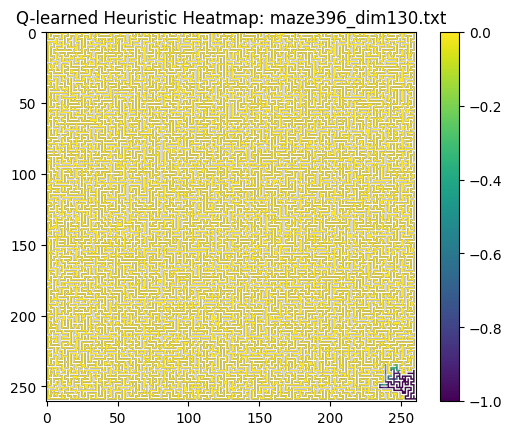

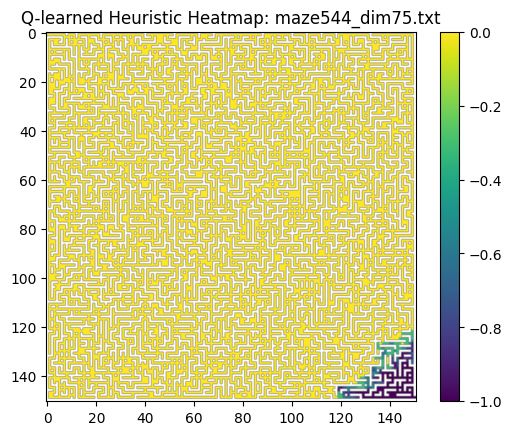

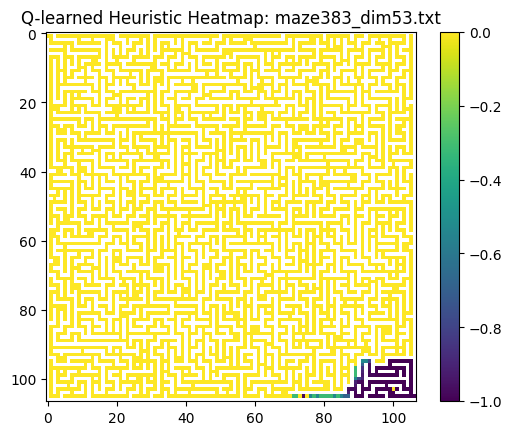

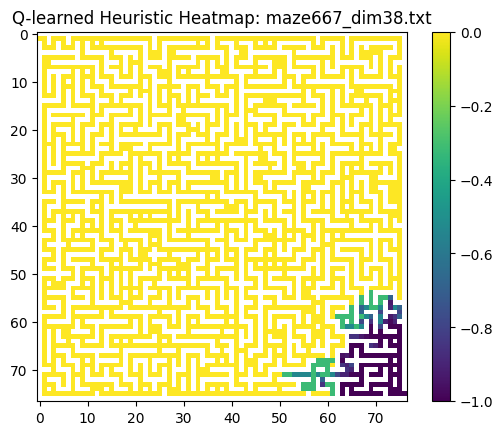

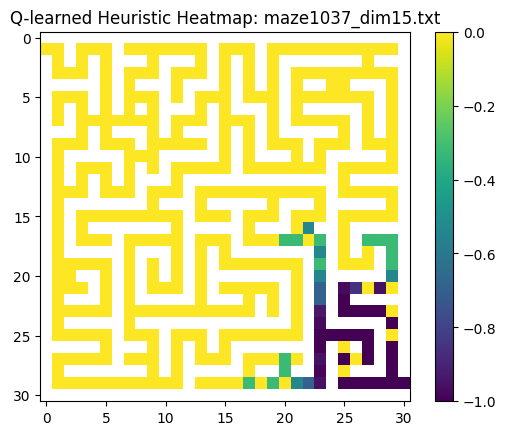

,maze,heuristic,runtime,path_length,nodes_expanded
0,maze396_dim130.txt,Manhattan,0.155752,704,35558
1,maze396_dim130.txt,Euclidean,0.207000,704,35537
2,maze396_dim130.txt,Q-learned,0.152355,704,35527
3,maze544_dim75.txt,Manhattan,0.060518,320,12651
4,maze544_dim75.txt,Euclidean,0.072141,320,12667


In [21]:
def visualize_heuristics_on_test_set(test_mazes, best_config, num_maps=5):
    actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    results = []

    for path in random.sample(test_mazes, min(num_maps, len(test_mazes))):
        maze = load_maze(path)
        free_cells = list(zip(*np.where(maze == 0)))
        start = free_cells[0]
        goal = free_cells[-1]

        Q = train_q_learning_reversed(
            maze, goal, actions,
            discount=best_config["discount"],
            explorationProb=best_config["explorationProb"],
            step_size=best_config["step_size"],
            num_sample_starts=best_config["num_sample_starts"],
            step_multiplier=best_config["step_multiplier"]
        )

        heuristics = {
            "Manhattan": manhattan_heuristic,
            "Euclidean": euclidean_heuristic,
            "Q-learned": q_heuristic
        }

        for name, h in heuristics.items():
            start_time = time.time()
            came_from, cost_so_far = astar(maze, start, goal, h)
            duration = time.time() - start_time
            path_len = cost_so_far.get(goal, float('inf'))
            num_nodes = len(cost_so_far)

            results.append({
                "maze": os.path.basename(path),
                "heuristic": name,
                "runtime": duration,
                "path_length": path_len,
                "nodes_expanded": num_nodes
            })

            if name == "Q-learned":
                values = np.full(maze.shape, np.nan)
                for r in range(maze.shape[0]):
                    for c in range(maze.shape[1]):
                        if maze[r, c] == 0:
                            state = (r, c)
                            qs = Q.get(state, {})
                            values[r, c] = max(qs.values()) if qs else 0
                plt.figure()
                plt.imshow(values, cmap="viridis")
                plt.title(f"Q-learned Heuristic Heatmap: {os.path.basename(path)}")
                plt.colorbar()
                plt.show()

    df = pd.DataFrame(results)
    df.to_csv("final_heuristic_comparison.csv", index=False)
    with open("final_heuristic_comparison.json", "w") as f:
        json.dump(results, f, indent=2)
    return df

# Run visualization + logging
best_config = results_df.sort_values("runtime").iloc[0].to_dict()
heuristic_eval_df = visualize_heuristics_on_test_set(test_mazes, best_config)
heuristic_eval_df.head()


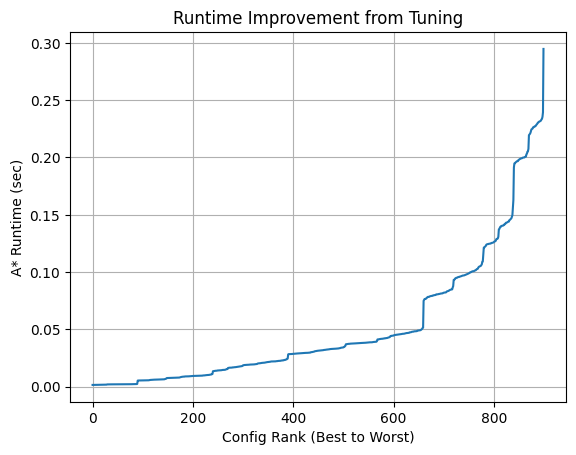

In [22]:
def plot_runtime_progression(results_df):
    sorted_df = results_df.sort_values("runtime").reset_index(drop=True)
    plt.figure()
    plt.plot(sorted_df.index, sorted_df["runtime"])
    plt.xlabel("Config Rank (Best to Worst)")
    plt.ylabel("A* Runtime (sec)")
    plt.title("Runtime Improvement from Tuning")
    plt.grid(True)
    plt.show()

plot_runtime_progression(results_df)


In [23]:
files.download("hyperparameter_results.csv")
files.download("hyperparameter_results.json")
files.download("final_heuristic_comparison.csv")
files.download("final_heuristic_comparison.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
df = pd.read_csv("final_heuristic_comparison.csv")

# Average metrics per heuristic
summary = df.groupby("heuristic").agg({
    "runtime": "mean",
    "path_length": "mean",
    "nodes_expanded": "mean"
}).reset_index()

print("Average Metrics by Heuristic:")
print(summary)

Average Metrics by Heuristic:
   heuristic   runtime  path_length  nodes_expanded
0  Euclidean  0.063863        310.8         11112.6
1  Manhattan  0.046887        310.8         10457.8
2  Q-learned  0.048643        310.8         11548.4


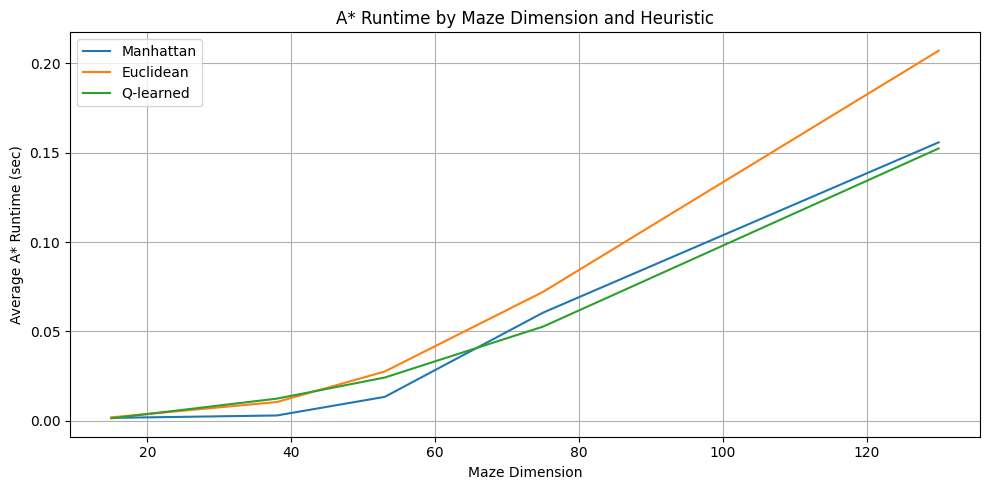

In [25]:
# Extract dimension from maze filename (assumes naming like 'maze407_dim142.txt')
df["dimension"] = df["maze"].str.extract(r'dim(\d+)').astype(float)

# Average runtime by dimension and heuristic
avg_time_by_dim = df.groupby(["dimension", "heuristic"])["runtime"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
for heuristic in df["heuristic"].unique():
    subset = avg_time_by_dim[avg_time_by_dim["heuristic"] == heuristic]
    plt.plot(subset["dimension"], subset["runtime"], label=heuristic)

plt.xlabel("Maze Dimension")
plt.ylabel("Average A* Runtime (sec)")
plt.title("A* Runtime by Maze Dimension and Heuristic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

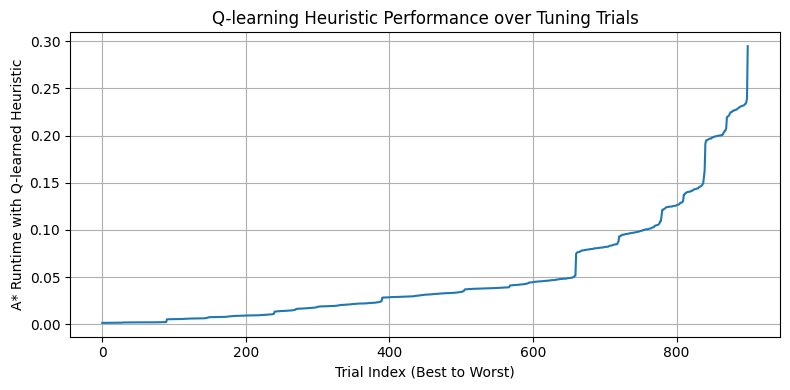

In [26]:
tuning_df = pd.read_csv("hyperparameter_results.csv")

# Sort by runtime for training curve
sorted_tuning = tuning_df.sort_values("runtime").reset_index(drop=True)

plt.figure(figsize=(8, 4))
plt.plot(sorted_tuning.index, sorted_tuning["runtime"])
plt.xlabel("Trial Index (Best to Worst)")
plt.ylabel("A* Runtime with Q-learned Heuristic")
plt.title("Q-learning Heuristic Performance over Tuning Trials")
plt.grid(True)
plt.tight_layout()
plt.show()

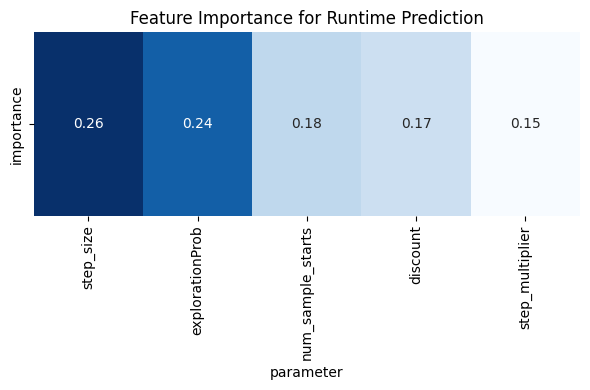

In [27]:
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

# Fit regressor and extract feature importances
features = ["discount", "explorationProb", "step_size", "num_sample_starts", "step_multiplier"]
X = tuning_df[features]
y = tuning_df["runtime"]

model = RandomForestRegressor(random_state=0)
model.fit(X, y)

importances = model.feature_importances_
importance_df = pd.DataFrame({"parameter": features, "importance": importances}).sort_values("importance", ascending=False)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(importance_df.set_index("parameter").T, annot=True, cmap="Blues", cbar=False)
plt.title("Feature Importance for Runtime Prediction")
plt.tight_layout()
plt.savefig("parameter_importance_heatmap.png")
plt.show()

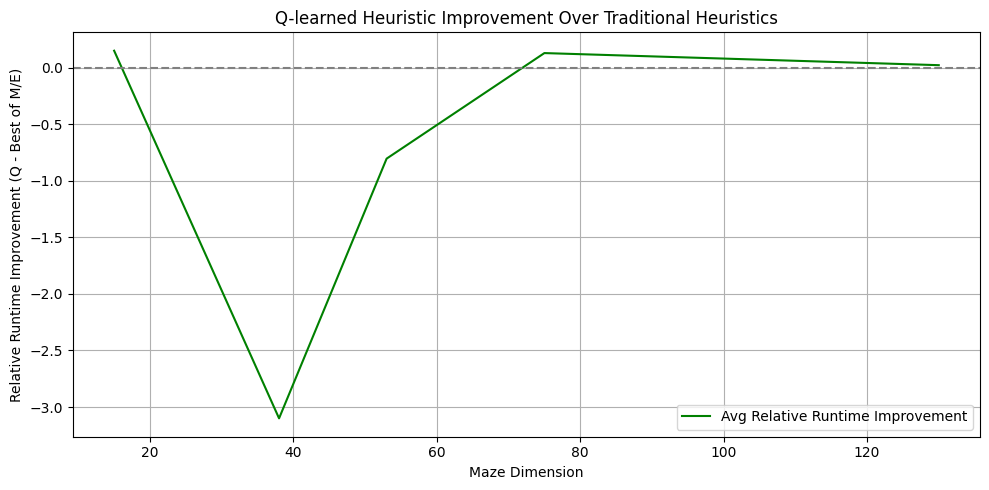

In [28]:
# Load and prepare data
df = pd.read_csv("final_heuristic_comparison.csv")
df["dimension"] = df["maze"].str.extract(r'dim(\d+)').astype(float)

# Align runtimes by heuristic per maze
pivot_df = df.pivot(index="maze", columns="heuristic", values=["runtime", "dimension"])
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df = pivot_df.dropna()
pivot_df["best_traditional"] = pivot_df[["runtime_Manhattan", "runtime_Euclidean"]].min(axis=1)

# Compute relative improvement: (traditional - qlearned) / traditional
pivot_df["relative_improvement"] = (
    (pivot_df["best_traditional"] - pivot_df["runtime_Q-learned"]) / pivot_df["best_traditional"]
)

pivot_df["dimension"] = pivot_df["dimension_Q-learned"]
agg = pivot_df.groupby("dimension")["relative_improvement"].agg(["mean", "count", "std"])
agg["sem"] = agg["std"] / agg["count"]**0.5  # standard error of the mean

plt.figure(figsize=(10, 5))
plt.plot(agg.index, agg["mean"], label="Avg Relative Runtime Improvement", color='green')
plt.fill_between(agg.index, agg["mean"] - agg["sem"], agg["mean"] + agg["sem"], color='green', alpha=0.3)

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Maze Dimension")
plt.ylabel("Relative Runtime Improvement (Q - Best of M/E)")
plt.title("Q-learned Heuristic Improvement Over Traditional Heuristics")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("qlearn_vs_traditional_by_dimension.png")
plt.show()

In [29]:
files.download("hyperparameter_results.csv")
files.download("hyperparameter_results.json")
files.download("final_heuristic_comparison.csv")
files.download("final_heuristic_comparison.json")
files.download("parameter_importance_heatmap.png")
files.download("qlearn_vs_traditional_by_dimension.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>